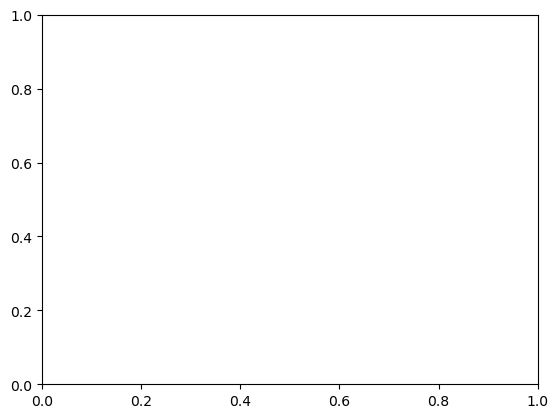

In [4]:
import asyncio
import json
import requests
import websockets
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from collections import deque

# -------------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------------
SYMBOL = "BTCUSDT".upper()
SNAPSHOT_URL = "https://api.binance.com/api/v3/depth"
# We’ll store incoming WS diff depth events here before we have the snapshot:
EVENT_BUFFER = deque()

# Adjust how many levels from the order book you want to display in the chart:
DISPLAY_LEVELS = 50
# Depth snapshot limit (how many levels we fetch in the REST call):
SNAPSHOT_LIMIT = 1000

# WebSocket URL for diff depth updates:
WS_URL = f"wss://stream.binance.com:9443/ws/{SYMBOL.lower()}@depth"

# -------------------------------------------------------------------------
# GLOBAL STATE
# -------------------------------------------------------------------------
orderbook_bids = {}  # price -> quantity
orderbook_asks = {}  # price -> quantity
last_update_id = None  # track the snapshot's lastUpdateId
snapshot_ready = False  # signals we have applied the snapshot once
fig, ax = plt.subplots()


def get_snapshot(symbol: str, limit: int) -> dict:
    """Fetch the initial order book snapshot from the REST API."""
    params = {"symbol": symbol, "limit": limit}
    resp = requests.get(SNAPSHOT_URL, params=params)
    resp.raise_for_status()
    return resp.json()


def initialize_local_orderbook(snapshot: dict):
    """
    Set up the local in-memory orderbook from snapshot data.
    snapshot: dict with keys ['lastUpdateId', 'bids', 'asks']
    """
    global orderbook_bids, orderbook_asks, last_update_id
    last_update_id = snapshot["lastUpdateId"]
    orderbook_bids = {float(price): float(qty) for price, qty in snapshot["bids"]}
    orderbook_asks = {float(price): float(qty) for price, qty in snapshot["asks"]}


def apply_diff_update(event: dict):
    """
    Apply a single WS diff depth update to the local orderbook.
    """
    global orderbook_bids, orderbook_asks, last_update_id

    # event["U"] = first update ID in event
    # event["u"] = last update ID in event
    # event["b"] = list of [price, quantity] for bids
    # event["a"] = list of [price, quantity] for asks

    # If the final update ID < our current last update ID, skip
    if event["u"] < last_update_id:
        return

    # If the first update ID is > last_update_id + 1, we lost data in between
    # and must re-sync. Here, we'll just print an error, but ideally you re-init.
    if event["U"] > last_update_id + 1:
        print("Orderbook out of sync. Need to re-initialize from snapshot.")
        return

    # Update BIDS
    for bid in event["b"]:
        price = float(bid[0])
        qty = float(bid[1])
        if qty == 0.0:
            # remove
            if price in orderbook_bids:
                del orderbook_bids[price]
        else:
            # upsert
            orderbook_bids[price] = qty

    # Update ASKS
    for ask in event["a"]:
        price = float(ask[0])
        qty = float(ask[1])
        if qty == 0.0:
            if price in orderbook_asks:
                del orderbook_asks[price]
        else:
            orderbook_asks[price] = qty

    # Finally update our last_update_id
    last_update_id = event["u"]


async def binance_ws_handler():
    """
    Connect to Binance WebSocket, read diff depth messages, and store them
    in EVENT_BUFFER until the snapshot is ready. After that, apply them directly.
    """
    global snapshot_ready

    async with websockets.connect(WS_URL) as ws:
        while True:
            try:
                raw_msg = await ws.recv()
                data = json.loads(raw_msg)
                if data.get("e") == "depthUpdate":
                    # If we haven't applied the snapshot yet, add to buffer
                    if not snapshot_ready:
                        EVENT_BUFFER.append(data)
                    else:
                        # Otherwise, apply right away
                        apply_diff_update(data)
            except websockets.exceptions.ConnectionClosed:
                print("WebSocket disconnected. Attempting to reconnect...")
                break
            except Exception as e:
                print(f"WS Error: {e}")
                break


async def sync_orderbook():
    """
    1. Wait for at least one event from the WS to get the first U (start update).
    2. Fetch snapshot from REST.
    3. Discard any WS events that have update IDs < snapshot lastUpdateId.
    4. Apply the remaining queued events.
    5. Mark snapshot_ready = True.
    """
    global snapshot_ready

    print("Waiting for the first WS event so we know where to start...")
    while not EVENT_BUFFER:
        await asyncio.sleep(0.1)

    first_event = EVENT_BUFFER[0]
    first_U = first_event["U"]
    print(f"First event U from WS: {first_U}")

    # Fetch snapshot
    print("Fetching snapshot from REST...")
    snapshot = get_snapshot(SYMBOL, SNAPSHOT_LIMIT)
    initialize_local_orderbook(snapshot)
    print(f"Snapshot lastUpdateId={last_update_id}")

    # We need to ensure the snapshot's lastUpdateId is not out of date:
    # If snapshot's lastUpdateId < first_U, we keep re-fetching until it isn't
    # (per Binance docs).
    while last_update_id < first_U:
        print(f"Snapshot lastUpdateId={last_update_id} is still < first_U={first_U}. Refetching...")
        snapshot = get_snapshot(SYMBOL, SNAPSHOT_LIMIT)
        initialize_local_orderbook(snapshot)
        await asyncio.sleep(0.5)

    # Now discard any events in buffer where event['u'] <= snapshot's lastUpdateId
    while EVENT_BUFFER and EVENT_BUFFER[0]["u"] <= last_update_id:
        EVENT_BUFFER.popleft()

    # Apply the remaining queued events
    print(f"Applying {len(EVENT_BUFFER)} buffered events...")
    while EVENT_BUFFER:
        event = EVENT_BUFFER.popleft()
        apply_diff_update(event)

    snapshot_ready = True
    print("Local orderbook is in sync with WS. Ready for real-time updates.")


def update_plot(frame):
    """
    Matplotlib FuncAnimation callback for rendering
    a more sophisticated real-time depth chart.
    We'll build a 'cumulative' style depth chart.
    """

    if not snapshot_ready:
        # If we're not synced yet, skip plotting
        ax.clear()
        ax.set_title("Awaiting initial sync...")
        return

    ax.clear()
    ax.set_title(f"Live Order Book Depth: {SYMBOL}")
    ax.set_xlabel("Price")
    ax.set_ylabel("Cumulative Quantity")

    # Sort bids in descending order by price
    sorted_bids = sorted(orderbook_bids.items(), key=lambda x: x[0], reverse=True)
    # Sort asks in ascending order by price
    sorted_asks = sorted(orderbook_asks.items(), key=lambda x: x[0])

    # Optionally limit the number of levels displayed
    top_bids = sorted_bids[:DISPLAY_LEVELS]
    top_asks = sorted_asks[:DISPLAY_LEVELS]

    if top_bids:
        bid_prices, bid_qtys = zip(*top_bids)
        # Build cumulative sizes (from best bid outward)
        # Because we sorted descending, we do a cumulative sum in that order
        bid_cum_qty = np.cumsum(bid_qtys)
        ax.plot(bid_prices, bid_cum_qty, color="green", label="Bids")
        ax.fill_between(bid_prices, bid_cum_qty, color="green", alpha=0.2)

    if top_asks:
        ask_prices, ask_qtys = zip(*top_asks)
        ask_cum_qty = np.cumsum(ask_qtys)
        ax.plot(ask_prices, ask_cum_qty, color="red", label="Asks")
        ax.fill_between(ask_prices, ask_cum_qty, color="red", alpha=0.2)

    ax.legend(loc="best")



In [5]:
# Start the WS handler in the background
ws_task = asyncio.create_task(binance_ws_handler())

# Start a sync process that:
# 1) Waits for first event
# 2) Fetches snapshot
# 3) Applies queued events
# 4) Marks snapshot ready
sync_task = asyncio.create_task(sync_orderbook())

# Start matplotlib in an async-friendly way
ani = FuncAnimation(fig, update_plot, interval=1000)
plt.show()

# We want our main task to run until the WS and sync tasks finish
# (though effectively, WS might run forever).
await asyncio.gather(ws_task, sync_task)

/var/folders/hr/bvfx5k3x75j3wnww5ytstx9w0000gn/T/ipykernel_53891/313633020.py:12: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update_plot, interval=1000)
/Users/juliandurnwalder/Documents/repos/binance/.pixi/envs/default/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Waiting for the first WS event so we know where to start...
First event U from WS: 64201805455
Fetching snapshot from REST...
Snapshot lastUpdateId=64201805770
Applying 0 buffered events...
Local orderbook is in sync with WS. Ready for real-time updates.


CancelledError: 